In [23]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
cols = ["Class", "Alcohol", "Malic_acid", "Ash", "Alcalinity_of_ash", "Magnesium",
        "Total_phenols", "Flavanoids", "Nonflavanoid_phenols", "Proanthocyanins",
        "Color_intensity", "Hue", "OD280_OD315", "Proline"]

df = pd.read_csv(url, header=None, names=cols)
print("Dataset shape:", df.shape)
display(df.head())

Dataset shape: (178, 14)


,Class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280_OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [25]:
target_col = "Class"
X = df.drop(columns=[target_col])
y = df[target_col]

# Adjust classes for XGBoost (expects 0-based labels)
y = y - 1

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred, average='weighted')
    }

results = []

In [29]:
dt_model = DecisionTreeClassifier(random_state=42, max_depth=4)
dt_model.fit(X_train, y_train)
results.append(evaluate_model("Decision Tree (Baseline)", dt_model, X_test, y_test))

In [30]:
rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=6,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42
)
rf_model.fit(X_train, y_train)
results.append(evaluate_model("Random Forest", rf_model, X_test, y_test))

In [31]:
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    learning_rate=0.1,
    max_depth=4,
    n_estimators=120,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.2,
    reg_lambda=1.0,
    eval_metric='mlogloss',
    random_state=42,
    use_label_encoder=False
)
xgb_model.fit(X_train, y_train)
results.append(evaluate_model("XGBoost", xgb_model, X_test, y_test))


In [32]:
results_df = pd.DataFrame(results)
print("\n✅ Model Performance Comparison:\n")
display(results_df)


✅ Model Performance Comparison:



,Model,Accuracy,Precision,Recall,F1-Score
0,Decision Tree (Baseline),0.944444,0.951389,0.944444,0.944961
1,Random Forest,1.000000,1.000000,1.000000,1.000000
2,XGBoost,1.000000,1.000000,1.000000,1.000000


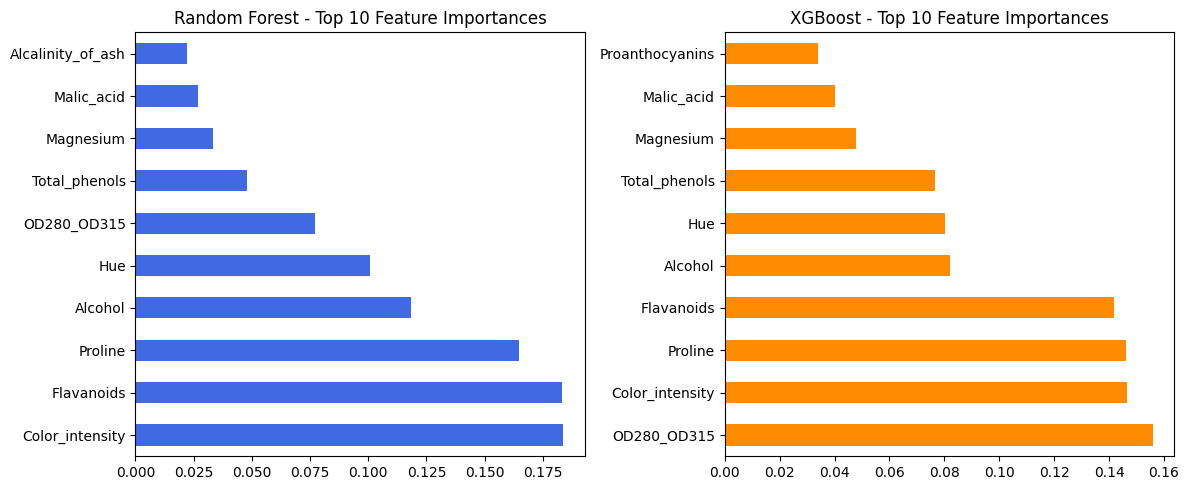

In [33]:
plt.figure(figsize=(12, 5))

# Random Forest Importance
plt.subplot(1, 2, 1)
rf_importances = pd.Series(rf_model.feature_importances_, index=df.columns[1:])
rf_importances.nlargest(10).plot(kind='barh', color='royalblue')
plt.title("Random Forest - Top 10 Feature Importances")

# XGBoost Importance
plt.subplot(1, 2, 2)
xgb_importances = pd.Series(xgb_model.feature_importances_, index=df.columns[1:])
xgb_importances.nlargest(10).plot(kind='barh', color='darkorange')
plt.title("XGBoost - Top 10 Feature Importances")

plt.tight_layout()
plt.show()

In [35]:
best_model_name = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
print(f"\n🏆 Best Performing Model: {best_model_name}")


🏆 Best Performing Model: Random Forest


In [37]:
import joblib

if best_model_name == "XGBoost":
    joblib.dump(xgb_model, "best_model.pkl")
elif best_model_name == "Random Forest":
    joblib.dump(rf_model, "best_model.pkl")
else:
    joblib.dump(dt_model, "best_model.pkl")

print("\n✅ Model saved as 'best_model.pkl' for Streamlit app integration.")


✅ Model saved as 'best_model.pkl' for Streamlit app integration.
